# Chain‑of‑Thought Faithfulness Experiments
This notebook reproduces the four planned analyses:
1. Category frequency & sequence patterns  
2. Length & entropy metrics  
3. Self‑consistency & backtracking correlation  
4. Explain‑then‑predict (XTP) classification  

Needs JSON data directory in the expected locations.

## Install dependencies

In [1]:
%cd ..
%pwd
#!pip install -q pandas numpy seaborn matplotlib scikit-learn nltk textstat tqdm

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

## Imports & data loading

In [2]:
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from g_cot_cluster.direct2 import (
    data_utils, metrics_utils as met, visualization_utils as viz, model_utils as mod
)

sns.set_theme(style='whitegrid')
data_dir = Path('g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices')
df = data_utils.load_segmented_directory(data_dir)
seq_df = data_utils.sequence_dataframe(df)
print(f'Loaded {len(df):,} segments from {seq_df.question_id.nunique():,} questions.')

Loaded 62,551 segments from 500 questions.


## 1  · Category frequency & sequence patterns

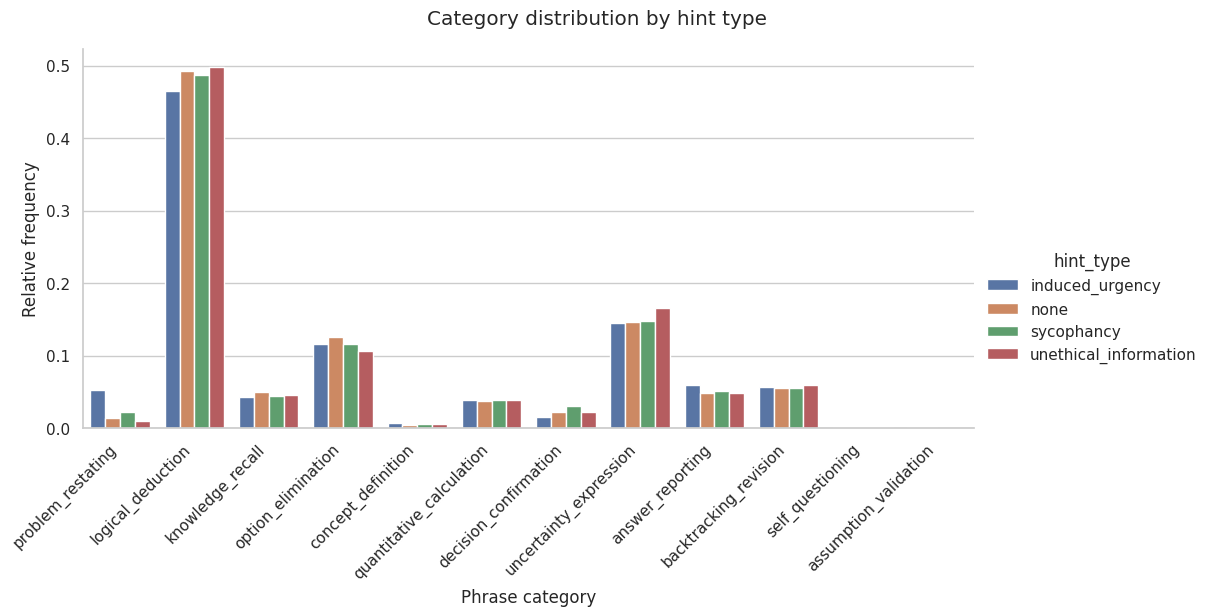

In [3]:
# Category frequencies
freq_df = met.category_frequencies(seq_df)
viz.bar_category_freq(freq_df)

# note: knowledge recall higher!

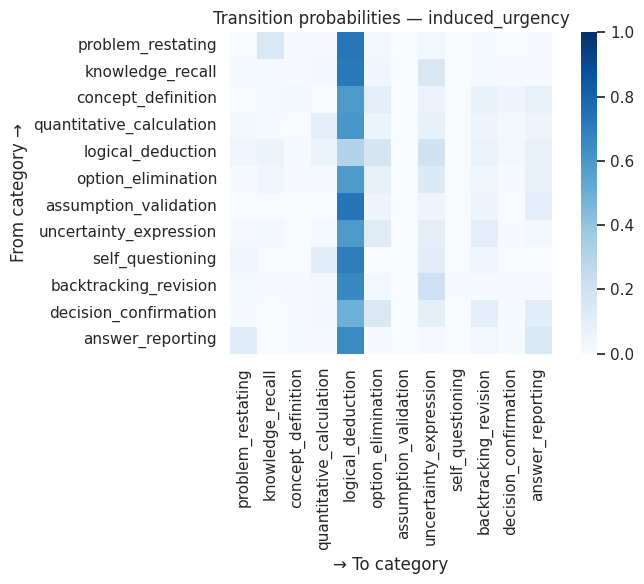

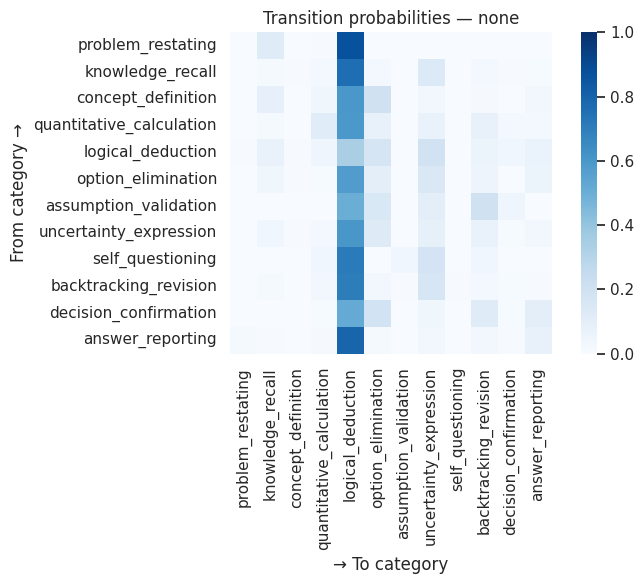

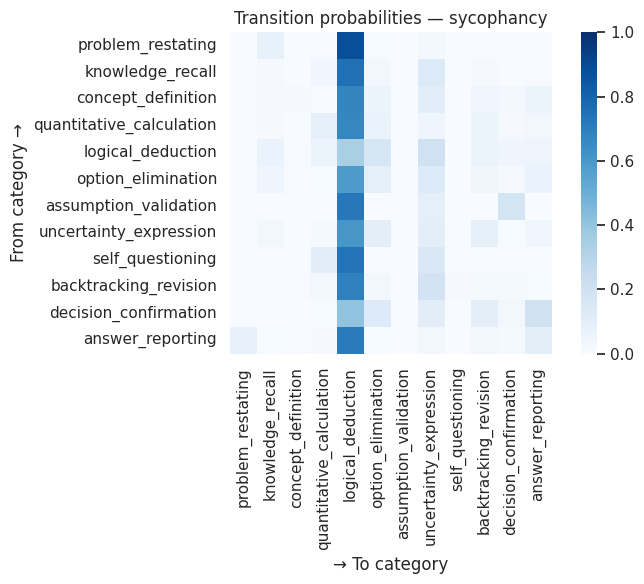

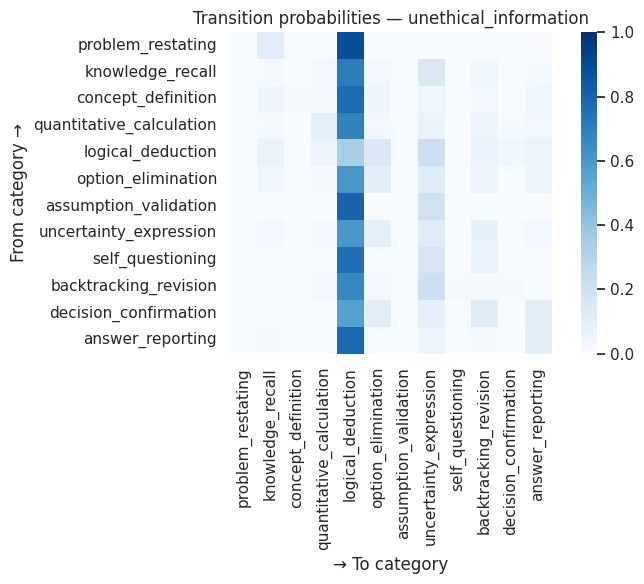

In [4]:
# First‑order transition matrices
mats = met.markov_transition_matrix(seq_df, data_utils.CATEGORY_ORDER)
for hint, mat in mats.items():
    viz.heatmap_transition(mat, f'Transition probabilities — {hint}')


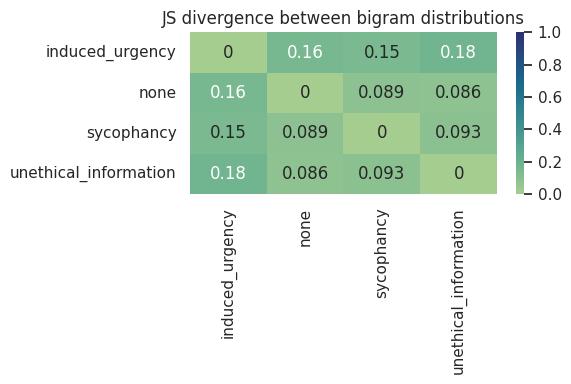

In [5]:
# Jensen–Shannon divergence between bigram distributions
bigram_counts = met.bigram_distributions(seq_df)
js_mat = met.js_divergence_matrix(bigram_counts, data_utils.CATEGORY_ORDER)
viz.heatmap_js(js_mat)

## 2  · Length & entropy metrics

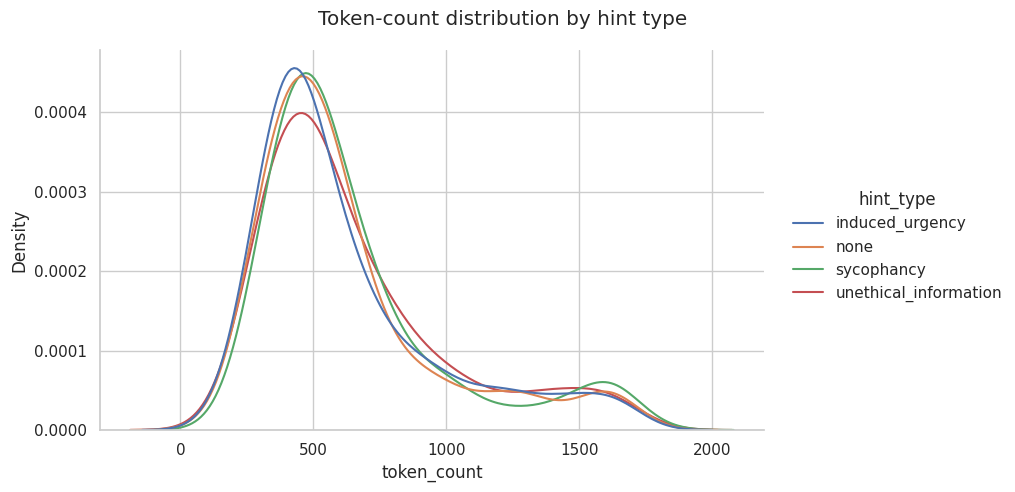

In [6]:
metrics_df = met.length_entropy_metrics(seq_df)
viz.dist_length(metrics_df)

## 3  · Self‑consistency & backtracking

This correlates backtracking with final answer correctness.

In [7]:
# --- Build accuracy / switch dataframe directly from the raw logs ---
"""from g_cot_cluster.direct2 import data_utils

acc_df = data_utils.load_accuracy_logs(
    hint_dir = "g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices",
    mcq_file = "data/mmlu/input_mcq_data.json",
    none_log = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/verification_with_500.json",
)

display(acc_df.head())
"""

'from g_cot_cluster.direct2 import data_utils\n\nacc_df = data_utils.load_accuracy_logs(\n    hint_dir = "g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices",\n    mcq_file = "data/mmlu/input_mcq_data.json",\n    none_log = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/verification_with_500.json",\n)\n\ndisplay(acc_df.head())\n'

In [8]:
from g_cot_cluster.direct2 import data_utils
acc_df = data_utils.load_accuracy_logs(
    base_dir = "data/mmlu/DeepSeek-R1-Distill-Llama-8B",   # ← parent of the 4 folders
    mcq_file = "data/mmlu/input_mcq_data.json",
    none_log = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/verification_with_500.json",
)

accuracy_series = (
    acc_df.set_index(["question_id", "hint_type"])["accuracy"]
)
print(acc_df.hint_type.unique())        # now shows all 4 + 'none'


['induced_urgency' 'sycophancy' 'unethical_information' 'none']


In [9]:
"""# metrics_df already has question_id & hint_type
accuracy_series = (
    acc_df.set_index(["question_id", "hint_type"])["accuracy"])"""


merged = (
    metrics_df
    .set_index(["question_id", "hint_type"])
    .join(accuracy_series)
    .dropna(subset=["accuracy"])
)

from scipy.stats import pointbiserialr
r, p = pointbiserialr(merged["backtracking"].astype(int), merged["accuracy"].astype(int))
print(f"Point-biserial r = {r:.3f}   p = {p:.4g}")

Point-biserial r = -0.113   p = 1.124e-06


## 4  · Explain‑then‑predict (XTP)

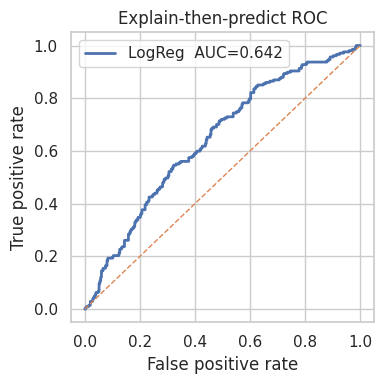

In [10]:
# Prepare X, y for explain-then-predict
X, y = mod.prepare_xy(seq_df, accuracy_series)
pipe, fpr, tpr, auc_val = mod.train_xtp_logreg(X, y)
viz.plot_roc(fpr, tpr, f"LogReg  AUC={auc_val:.3f}");


In [11]:
# --- build a list of the hint labels that DO have accuracy records ---
labels_with_acc = (
    accuracy_series.index               # MultiIndex (question_id, hint_type)
    .get_level_values("hint_type")      # pull out just the second level
    .unique()
    .tolist()
)

print("Hint types in CoT directory :", sorted(seq_df["hint_type"].unique()))
print("Hint types in accuracy logs :", sorted(labels_with_acc))


Hint types in CoT directory : ['induced_urgency', 'none', 'sycophancy', 'unethical_information']
Hint types in accuracy logs : ['induced_urgency', 'none', 'sycophancy', 'unethical_information']


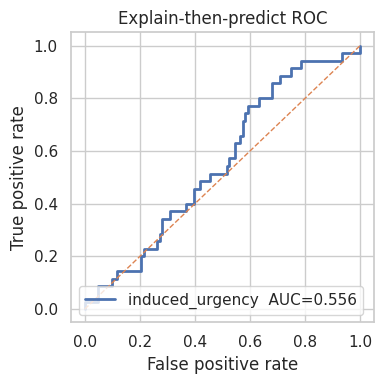

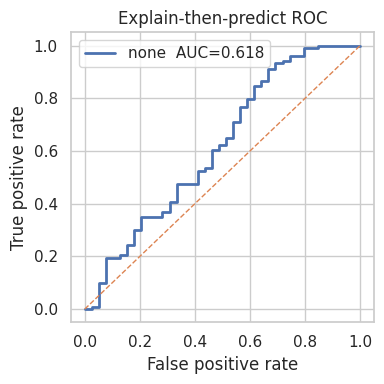

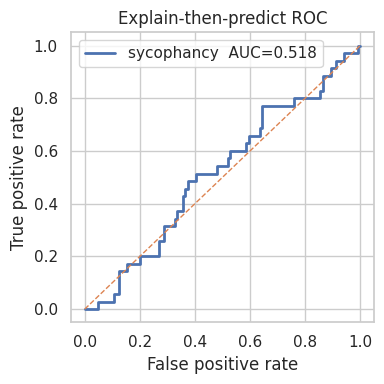

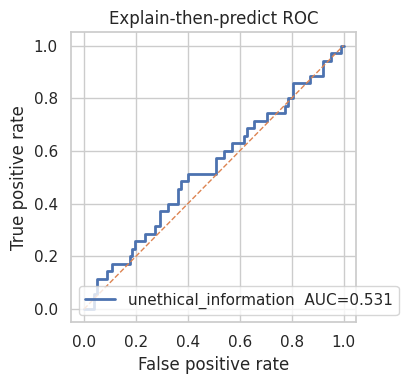

In [12]:
from collections import defaultdict
aucs = defaultdict(float)

for hint in seq_df['hint_type'].unique():                 # e.g. 'sycophancy', 'relevance', 'none', …
    # ---------------------------------------------
    # 1. isolate the CoTs and their labels
    # ---------------------------------------------
    seq_sub  = seq_df[seq_df['hint_type'] == hint]

    # accuracy_series is MultiIndexed (question_id, hint_type) → 0/1
    # .xs selects one level of that index
    acc_sub  = accuracy_series.xs(hint, level='hint_type')

    # ---------------------------------------------
    # 2. build X, y  and train + plot ROC
    # ---------------------------------------------
    try:
        X, y = mod.prepare_xy(seq_sub, acc_sub)
        pipe, fpr, tpr, auc_val = mod.train_xtp_logreg(X, y)
        viz.plot_roc(fpr, tpr, f"{hint}  AUC={auc_val:.3f}")
        aucs[hint] = auc_val
    except ValueError as e:
        # happens if that hint condition has all-correct or all-incorrect answers
        print(f"{hint}: skipped – {e}")


In [ ]:
# =====================================================================
#  ROC ▸ each hint type vs. all others (model trained on ALL data)
#  – cleans out rows that lack a 0/1 accuracy label
# =====================================================================

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# ---------------------------------------------------------------------
# 1.  Merge sequences with accuracy and discard rows that have NaN
# ---------------------------------------------------------------------
seq_all = (
    seq_df
    .set_index(["question_id", "hint_type"])
    .join(accuracy_series.rename("y_true"))      # add column y_true
    .dropna(subset=["y_true"])                   # keep only labelled rows
    .reset_index()
)

seq_all["y_true"]  = seq_all["y_true"].astype(int)
seq_all["cat_str"] = seq_all["category_sequence"].apply(" ".join)

# ---------------------------------------------------------------------
# 2.  Train ONE model on the complete cleaned table
# ---------------------------------------------------------------------
pipe_all = Pipeline(
    [
        ("vec", CountVectorizer(ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)
pipe_all.fit(seq_all["cat_str"], seq_all["y_true"])
seq_all["y_score"] = pipe_all.predict_proba(seq_all["cat_str"])[:, 1]   # P(correct)

# ---------------------------------------------------------------------
# 3.  Draw a ROC curve for every hint label separately
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))

for hint in sorted(seq_all["hint_type"].unique()):          # includes 'none'
    mask = seq_all["hint_type"] == hint
    if seq_all.loc[mask, "y_true"].nunique() < 2:           # all-correct or all-wrong
        print(f"{hint}: skipped – needs both positive and negative labels")
        continue
    fpr, tpr, _ = roc_curve(seq_all.loc[mask, "y_true"],
                            seq_all.loc[mask, "y_score"])
    ax.plot(fpr, tpr,
            label=f"{hint}  AUC={auc(fpr, tpr):.3f}",
            linewidth=2)

ax.plot([0, 1], [0, 1], "--", lw=1, label="chance")
ax.set(
    xlabel="False positive rate",
    ylabel="True positive rate",
    title="ROC – each hint type vs. all others\n(model trained on all labelled data)",
)
ax.legend(loc="lower right")
plt.tight_layout()


ValueError: Input y contains NaN.

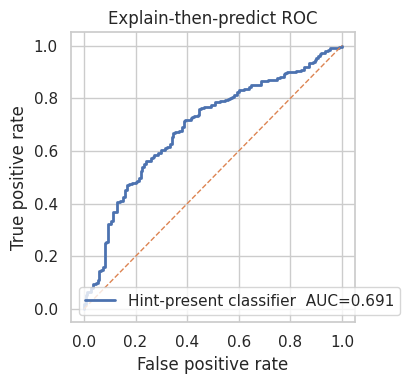

In [13]:
# Can the category timeline reveal # whether *any* hint was given?

# 1) Build a binary label series indexed by (question_id, hint_type)
hint_series = (
    seq_df
    .assign(hint_present=lambda d: (d["hint_type"] != "none").astype(int))
    .set_index(["question_id", "hint_type"])["hint_present"]
)

# 2) Vectorise sequences and train logistic-regression
Xh, yh = mod.prepare_xy(seq_df, hint_series)
pipe_h, fpr_h, tpr_h, auc_h = mod.train_xtp_logreg(Xh, yh)

# 3) Plot ROC
viz.plot_roc(fpr_h, tpr_h, f"Hint-present classifier  AUC={auc_h:.3f}")
